In [2]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

## Read in the NBA gamelog data in a pandas dataframe

In [3]:
# read gameLog data from json files and convert it to dataframe.
data_path = 'Data/gamelog/'

df = pd.DataFrame()
yr = 1985 # starting year (data available from 1985 - 2016)
for i in range(0,32):
    yr_str = str(yr)+'-'+str(yr+1)[2:]
    yr += 1
    with open(data_path+'gameLog_'+yr_str+'.json') as json_data:
        d = json.load(json_data)
        headers = d['resultSets'][0]['headers']
        df = df.append(d['resultSets'][0]['rowSet'])
        
df.columns = headers

In [4]:
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,21985,1610612757,POR,Portland Trail Blazers,0028500541,1986-02-01,POR vs. LAC,W,240,62,...,27,35,46,13,3,17,29,156,35,0
1,21985,1610612755,PHL,Philadelphia 76ers,0028500623,1986-02-19,PHL vs. POR,W,240,52,...,35,45,31,15,8,20,30,153,20,0
2,21985,1610612744,GOS,Golden State Warriors,0028500001,1986-01-15,GOS vs. UTH,W,240,62,...,37,53,37,14,5,15,25,150,46,0
3,21985,1610612745,HOU,Houston Rockets,0028500769,1986-03-15,HOU vs. LAC,W,240,64,...,33,49,50,14,6,10,23,148,32,0
4,21985,1610612751,NJN,New Jersey Nets,0028500031,1985-10-30,NJN vs. IND,W,315,55,...,47,65,27,14,6,20,36,147,9,0


## Data Cleaning

In [5]:
# replace '@' by 'vs.' in column matchup
df['MATCHUP'] = df['MATCHUP'].str.replace('@','vs.')

# replace 'W' and 'L' to 1 and 0 in column WL
df.WL.replace(['W','L'],[1,0], inplace=True)

# drop columns with missing values, if any
df = df.dropna()

### Using df.dropna() removes the rows with 'na' values, but it does not rearrage the index of the table. So, need to rearrage the index of the table so that there wouldn't be missing indices.


In [6]:
# rearrange the index numbers
df.index = np.linspace(0,df.index.size-1,df.index.size).astype(int)

In [23]:
#df[(df['GAME_DATE']=='2000-10-31') & ((df['TEAM_ID']==1610612741) | (df['TEAM_ID']==1610612758))].loc[:,'FGM':'PF']
d1 = df[(df['GAME_DATE']=='2000-10-31') & (df['TEAM_ID']==1610612741)].loc[:,'SEASON_ID':'PF']

In [46]:
d2 = df[(df['GAME_DATE']=='2001-04-18') & (df['TEAM_ID']==1610612761)].loc[:,'FGM':'PF']

In [48]:
df[df['GAME_DATE']=='2001-04-21']
#pd.concat([d1,d2],axis=1, ignore_index=False)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE


## Extract TEAM_ID, TEAM_ABBREVIATION, and TEAM_NAMES

In [8]:
# function to get team_id and team_abbreviations and team_names 
# (some teams have multiple abbreviations and names)
# return a dictionary
def team_id_abv_nm():
    id_abv_nm_dict = {k:[v['TEAM_ABBREVIATION'].drop_duplicates().tolist(), v['TEAM_NAME'].drop_duplicates().tolist()]
                      for k,v in df[['TEAM_ID','TEAM_ABBREVIATION', 'TEAM_NAME']].drop_duplicates().groupby('TEAM_ID')}
    return id_abv_nm_dict

tm_id_abv_nm = team_id_abv_nm()

In [9]:
tm_id_abv_nm

{1610612737: [['ATL'], ['Atlanta Hawks']],
 1610612738: [['BOS'], ['Boston Celtics']],
 1610612739: [['CLE'], ['Cleveland Cavaliers']],
 1610612740: [['NOH', 'NOK', 'NOP'],
  ['New Orleans Hornets',
   'New Orleans/Oklahoma City Hornets',
   'New Orleans Pelicans']],
 1610612741: [['CHI'], ['Chicago Bulls']],
 1610612742: [['DAL'], ['Dallas Mavericks']],
 1610612743: [['DEN'], ['Denver Nuggets']],
 1610612744: [['GOS', 'GSW'], ['Golden State Warriors']],
 1610612745: [['HOU'], ['Houston Rockets']],
 1610612746: [['LAC'], ['Los Angeles Clippers', 'LA Clippers']],
 1610612747: [['LAL'], ['Los Angeles Lakers']],
 1610612748: [['MIA'], ['Miami Heat']],
 1610612749: [['MIL'], ['Milwaukee Bucks']],
 1610612750: [['MIN'], ['Minnesota Timberwolves']],
 1610612751: [['NJN', 'BKN'], ['New Jersey Nets', 'Brooklyn Nets']],
 1610612752: [['NYK'], ['New York Knicks']],
 1610612753: [['ORL'], ['Orlando Magic']],
 1610612754: [['IND'], ['Indiana Pacers']],
 1610612755: [['PHL', 'PHI'], ['Philadelphia 

## Function to look up team_id and team_name, given a team_abreviation

In [10]:
def lookup_team_id_nm(tm_dict,team_abv):
    for k,v in tm_dict.items():
        for value in v[0]:
            if value == team_abv:
                return k, v[1]
    else:
        print(team_abv+' is not a valid team abreviation.')

In [11]:
team_id_name = lookup_team_id_nm(tm_id_abv_nm, 'MEM')
print(team_id_name)

(1610612763, ['Vancouver Grizzlies', 'Memphis Grizzlies'])


## Add a new column of opponent team ids in the dateframe

In [12]:
# get team_id of the teams to add a new column into the dataframe
matchup_team_ids = [lookup_team_id_nm(tm_id_abv_nm,df['MATCHUP'][i][-3:])[0] for i in range(len(df.index))]

# add a new column of opponent_id to the dataframe
df['OPPONENT_ID'] = matchup_team_ids
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,OPPONENT_ID
0,21985,1610612757,POR,Portland Trail Blazers,0028500541,1986-02-01,POR vs. LAC,1.0,240,62,...,35,46,13,3,17,29,156,35,0,1610612746
1,21985,1610612755,PHL,Philadelphia 76ers,0028500623,1986-02-19,PHL vs. POR,1.0,240,52,...,45,31,15,8,20,30,153,20,0,1610612757
2,21985,1610612744,GOS,Golden State Warriors,0028500001,1986-01-15,GOS vs. UTH,1.0,240,62,...,53,37,14,5,15,25,150,46,0,1610612762
3,21985,1610612745,HOU,Houston Rockets,0028500769,1986-03-15,HOU vs. LAC,1.0,240,64,...,49,50,14,6,10,23,148,32,0,1610612746
4,21985,1610612751,NJN,New Jersey Nets,0028500031,1985-10-30,NJN vs. IND,1.0,315,55,...,65,27,14,6,20,36,147,9,0,1610612754


## Sort the dataframe by TEAM_ID, OPPENENT_ID, and, WL

In [13]:
# sort data by TEAM_ID, OPPONENT_ID and GAME_DATE
df = df.sort_values(['TEAM_ID', 'OPPONENT_ID','WL'])
df.index = np.linspace(0,df.index.size-1,df.index.size)
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,OPPONENT_ID
0.0,21985,1610612737,ATL,Atlanta Hawks,0028500453,1986-01-18,ATL vs. BOS,0.0,265,49,...,43,30,12,10,11,25,122,-3,0,1610612738
1.0,21985,1610612737,ATL,Atlanta Hawks,0028500760,1986-03-14,ATL vs. BOS,0.0,240,49,...,39,28,7,3,10,28,114,-7,0,1610612738
2.0,21985,1610612737,ATL,Atlanta Hawks,0028500258,1985-12-10,ATL vs. BOS,0.0,240,48,...,37,23,13,7,20,22,110,-4,0,1610612738
3.0,21985,1610612737,ATL,Atlanta Hawks,0028500045,1985-11-01,ATL vs. BOS,0.0,240,41,...,39,22,12,2,14,35,105,-4,0,1610612738
4.0,21985,1610612737,ATL,Atlanta Hawks,0028500200,1985-11-30,ATL vs. BOS,0.0,240,35,...,40,16,10,6,18,17,97,-5,0,1610612738


In [14]:
# count the number of games played by each team
gameCount_byTeam = df.TEAM_ID.value_counts().sort_index()

## Number of games played by each team since 1985

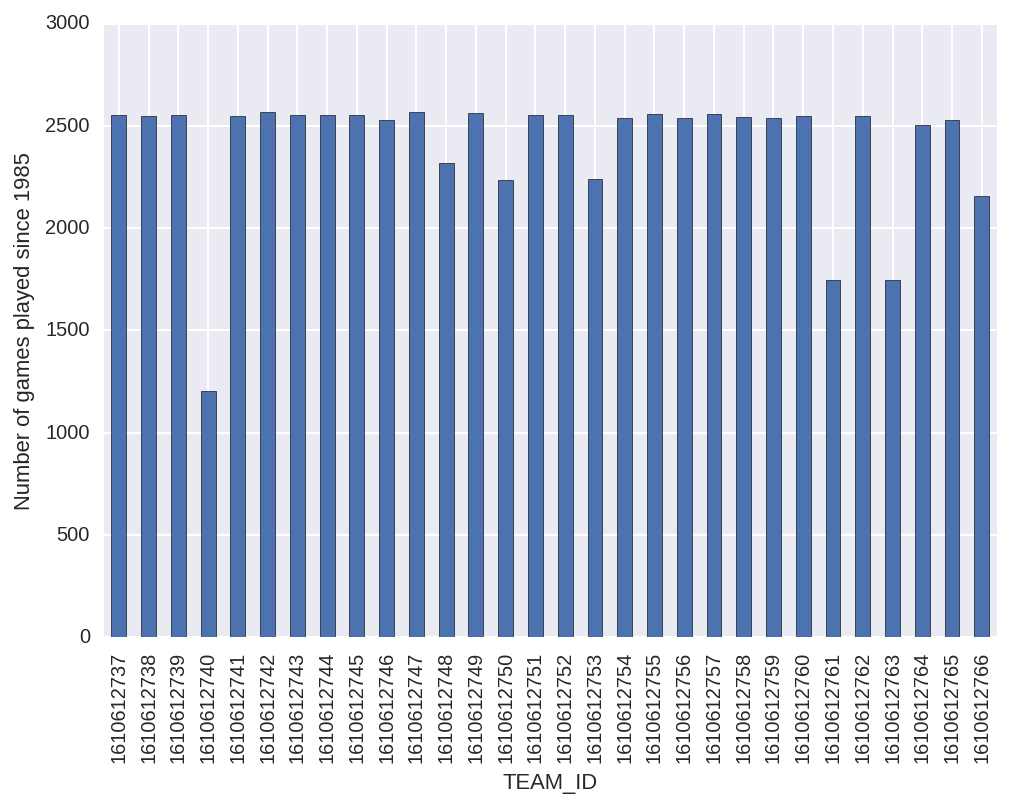

In [15]:
gameCount_byTeam.plot.bar()
plt.xlabel('TEAM_ID')
plt.ylabel('Number of games played since 1985')

# Choose Teams to look at

In [16]:
# List of teams available:
#
# [ ATL, BOS, CLE, NOH, CHI, DAL, DEN, GOS, HOU, LAC, LAL, MIA, MIL, MIN, NJN,
#   NYK, ORL, IND, PHL, PHX, POR, SAC, SAN, SEA, TOR, UTH, VAN, WAS, DET, CHH ]

team    = 'CHI'  # Chicago Bulls
oppTeam = 'BOS'  # Boston Celtics

teamID = lookup_team_id_nm(tm_id_abv_nm, team)
oppTeamID = lookup_team_id_nm(tm_id_abv_nm, oppTeam)
print('(Team ID, Team Abbreviation, Team Name)                : ({0}, {1}, {2})'.format(teamID[0], team, teamID[1]))
print('(Opp. Team ID, Opp. Team Abbreviation, Opp. Team Name) : ({0}, {1}, {2})'.format(oppTeamID[0], oppTeam, oppTeamID[1]))

(Team ID, Team Abbreviation, Team Name)                : (1610612741, CHI, ['Chicago Bulls'])
(Opp. Team ID, Opp. Team Abbreviation, Opp. Team Name) : (1610612738, BOS, ['Boston Celtics'])


## Get data for your team

In [17]:
data_for_team = df[df['TEAM_ID']==teamID[0]]
data_for_team.tail(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,OPPONENT_ID
11400.0,22014,1610612741,CHI,Chicago Bulls,0021400263,2014-12-03,CHI vs. CHA,1.0,240,37,...,49,27,4,1,13,18,102,7,1,1610612766
11401.0,22014,1610612741,CHI,Chicago Bulls,0021401051,2015-03-23,CHI vs. CHA,1.0,240,37,...,46,21,5,7,6,20,98,12,1,1610612766
11402.0,22015,1610612741,CHI,Chicago Bulls,0021500132,2015-11-13,CHI vs. CHA,1.0,240,37,...,57,27,4,6,11,16,102,5,1,1610612766
11403.0,22016,1610612741,CHI,Chicago Bulls,0021600517,2017-01-02,CHI vs. CHA,1.0,240,42,...,45,23,10,9,12,17,118,7,1,1610612766
11404.0,22016,1610612741,CHI,Chicago Bulls,0021600991,2017-03-13,CHI vs. CHA,1.0,240,41,...,50,29,6,5,10,20,115,6,1,1610612766


## Bar graph of number of games played by your team against opponent teams since 1985

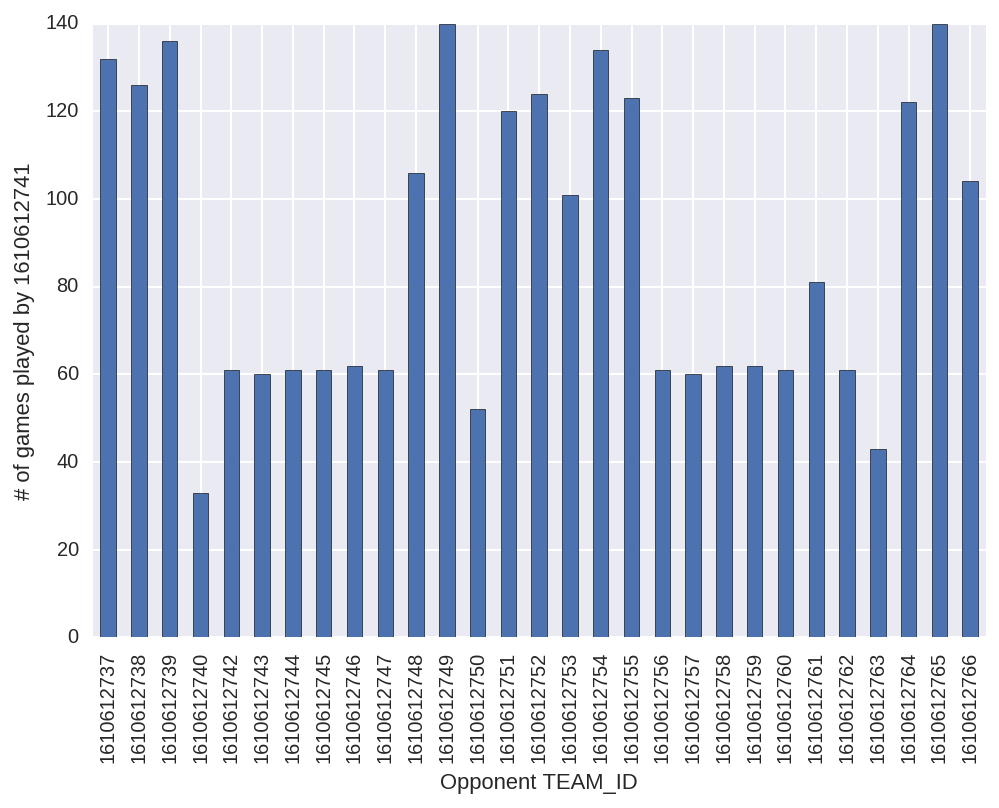

In [18]:
gameCount_ofTeam_byOpponent = pd.Series(data_for_team['OPPONENT_ID'].tolist()).value_counts().sort_index()
gameCount_ofTeam_byOpponent.plot.bar()
plt.xlabel('Opponent TEAM_ID')
plt.ylabel('# of games played by '+str(teamID[0]))

In [21]:
data_for_team.groupby(['OPPONENT_ID','WL'])['SEASON_ID'].count()

OPPONENT_ID  WL 
1610612737   0.0    58
             1.0    74
1610612738   0.0    55
             1.0    71
1610612739   0.0    62
             1.0    74
1610612740   0.0    12
             1.0    21
1610612742   0.0    34
             1.0    27
1610612743   0.0    31
             1.0    29
1610612744   0.0    24
             1.0    37
1610612745   0.0    35
             1.0    26
1610612746   0.0    28
             1.0    34
1610612747   0.0    34
             1.0    27
1610612748   0.0    49
             1.0    57
1610612749   0.0    51
             1.0    89
1610612750   0.0    22
             1.0    30
1610612751   0.0    46
             1.0    74
1610612752   0.0    47
             1.0    77
1610612753   0.0    48
             1.0    53
1610612754   0.0    62
             1.0    72
1610612755   0.0    56
             1.0    67
1610612756   0.0    29
             1.0    32
1610612757   0.0    33
             1.0    27
1610612758   0.0    28
             1.0    34
1610612759   0.0 

In [19]:
win_loss_count = data_for_team.groupby(['OPPONENT_ID','WL'])['SEASON_ID'].count()

In [20]:
# win_loss_of_team.index.levels[0].tolist()
# len(win_loss_of_team.index.labels[1].tolist())

In [21]:
if win_loss_count.index.size != 58:
    print('Something is wrong.!!!')

winLoss_records = []
for i in range(29):
    winLoss_records.append([win_loss_count.index.levels[0][i], win_loss_count[i*2], win_loss_count[1+i*2]])
    
winLoss_records_byTeam = {teamID[0]: np.array(winLoss_records)}
# winLoss_records_byTeam

## Bar graph of win/loss percentage of your team against all its opponent teams

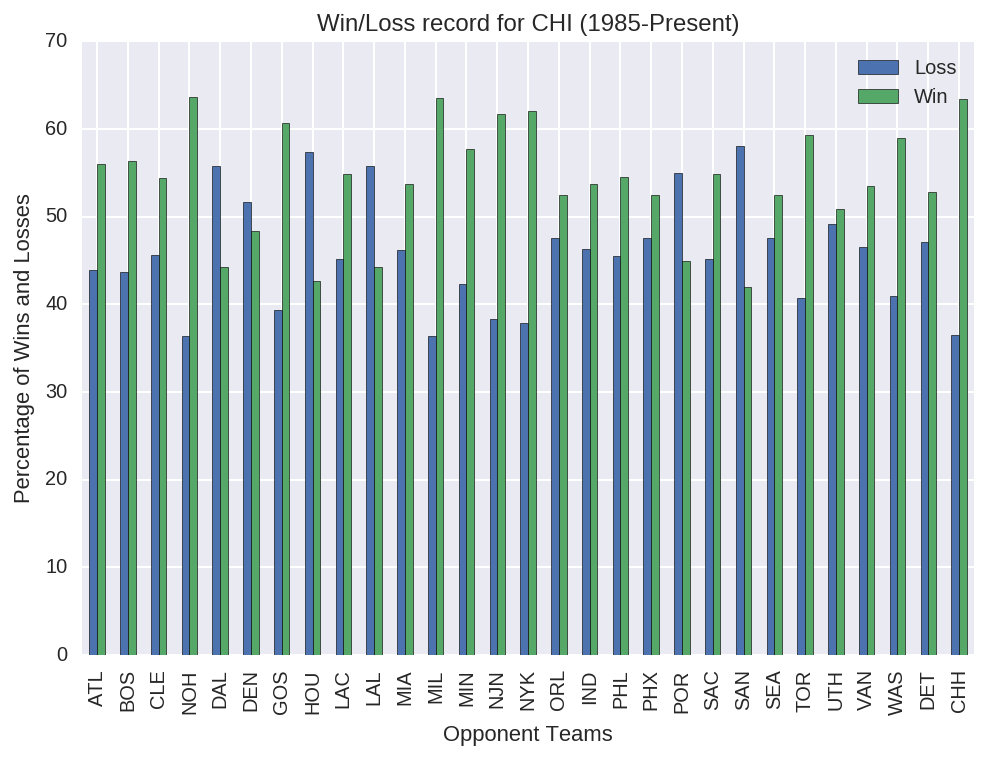

In [22]:
df2 = pd.DataFrame(winLoss_records_byTeam[teamID[0]][:,1:],columns=['Loss','Win'])
df2['Loss'] = (df2['Loss']/gameCount_ofTeam_byOpponent.tolist())*100
df2['Win'] = (df2['Win']/gameCount_ofTeam_byOpponent.tolist())*100
df2.index = [tm_id_abv_nm[item][0][0] for item in win_loss_count.index.levels[0]]
df2.plot.bar()
plt.xlabel('Opponent Teams')
plt.ylabel('Percentage of Wins and Losses')
plt.title('Win/Loss record for '+team+' (1985-Present)')

## Field Goal percentages of your team against the opponent team for the games won and lost

In [23]:
OPP_WIN = data_for_team[(data_for_team['WL']==1) & 
                        (data_for_team['OPPONENT_ID']==oppTeamID[0])].sort_values('GAME_DATE')
OPP_LOSS = data_for_team[(data_for_team['WL']==0) & 
                         (data_for_team['OPPONENT_ID']==oppTeamID[0])].sort_values('GAME_DATE')
OPP_WIN_dates = matplotlib.dates.date2num(pd.to_datetime(OPP_WIN['GAME_DATE']).tolist())
OPP_LOSS_dates = matplotlib.dates.date2num(pd.to_datetime(OPP_LOSS['GAME_DATE']).tolist())

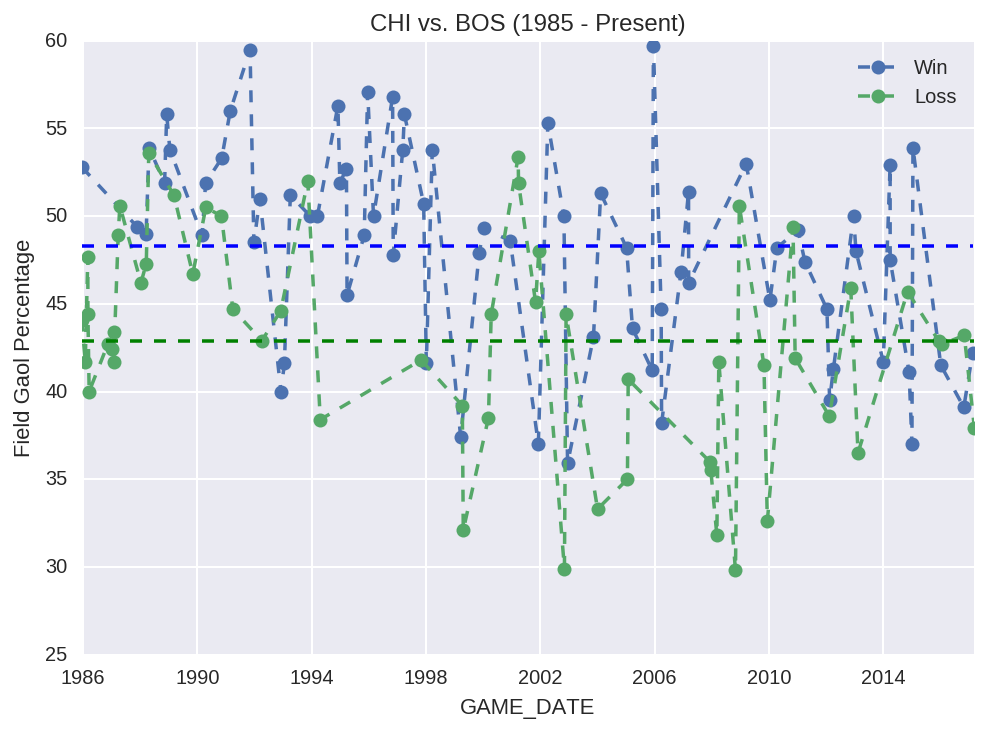

In [24]:
plt.plot_date(OPP_WIN_dates,OPP_WIN['FG_PCT']*100,'o--')
plt.plot_date(OPP_LOSS_dates,OPP_LOSS['FG_PCT']*100,'o--')
plt.plot((np.min(OPP_WIN_dates),np.max(OPP_WIN_dates)),(OPP_WIN['FG_PCT'].mean()*100,OPP_WIN['FG_PCT'].mean()*100), 'b--')
plt.plot((np.min(OPP_LOSS_dates),np.max(OPP_LOSS_dates)),(OPP_LOSS['FG_PCT'].mean()*100,OPP_LOSS['FG_PCT'].mean()*100), 'g--')
plt.xlabel('GAME_DATE')
plt.ylabel('Field Gaol Percentage')
plt.title(team+' vs. '+oppTeam+' (1985 - Present)')
plt.legend(['Win','Loss'])


# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics, cross_validation
import time

In [26]:
def prepare_data(dframe, teamID, oppTeamID):
    data_all_teamID = dframe[(dframe['TEAM_ID']==teamID) & (dframe['OPPONENT_ID']==oppTeamID)]
    X = data_all_teamID[['WL','FGM','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','AST','STL','BLK','TOV','PF']].copy()
    y = X['WL'].copy()
    # set the first column of X to be an intercept column and set its value to 1
    X['WL'] = 1 # intercept column
    rnd_indx = np.random.permutation(y.index.size)
    X = np.array(X.iloc[rnd_indx])
    y = np.array(y.iloc[rnd_indx])
    return X, y

In [27]:
# prepare data for logistic regression
# X --> feature matrix
# y --> binary category (1 or 0)
X, y = prepare_data(df, teamID[0], oppTeamID[0])

In [28]:
# instantiate a Logistic regression model, and fit with X and y
lrModel = LogisticRegression()
#lrModel = lrModel.fit(X,y)

In [29]:
# check the accuracy on the training set
print('')
print( '################# Logistic Regression report ####################')

# evaluate the model by splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lrModel2 = LogisticRegression()
lrModel2.fit(X_train, y_train)

# predict class labels from the test set
predicted = lrModel2.predict(X_test)
print('')
print( 'Actual classes of the test data   : ', y_test)
print( '')
print( 'Predicted classes of the test data: ', predicted)
print( '')

# generate class probabilities
probs = lrModel2.predict_proba(X_test)
#print probs

cm = metrics.confusion_matrix(y_test, predicted)
print( 'Confusion matrix')
print( 'Class labels: 0     1')
print( '             ', cm[0][0], '  ', cm[0][1])
print( '             ', cm[1][0], '  ', cm[1][1])

print( '')
print( 'Classification report:')
print( metrics.classification_report(y_test, predicted))
print( '')

# evaluate the model using 10-fold cross-validation
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
scoring = 'accuracy'
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=kfold)
print('10-fold cross-validation accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))

# predicting the probability of winning
#features = np.array([1, 48, 86, 1, 2, 13, 27, 10, 27, 37, 13, 7, 20, 22])
#print lrModel.predict_proba(features.reshape(1,-1))


################# Logistic Regression report ####################

Actual classes of the test data   :  [ 1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.
  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  1.
  1.  1.]

Predicted classes of the test data:  [ 0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.
  1.  0.]

Confusion matrix
Class labels: 0     1
              14    2
              6    16

Classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.88      0.78        16
        1.0       0.89      0.73      0.80        22

avg / total       0.81      0.79      0.79        38


10-fold cross-validation accuracy: 0.859 (0.136)


In [181]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=14)
scores = cross_val_score(clf, X, y, scoring='accuracy')
print('Accuracy: {0:.1f}% ({1:.1f}%)'.format(scores.mean()*100, scores.std()*100))

Accuracy: 68.8% (10.3%)


In [31]:
from sklearn.grid_search import GridSearchCV
parameter_space = {
    'max_features': [2, 10, 'auto'],
    'n_estimators': [100,],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6]
}
clf = RandomForestClassifier(random_state=14)
grid = GridSearchCV(clf, parameter_space)
grid.fit(X, y)
print('Accuracy: {0:.1f}%'.format(grid.best_score_ * 100))

Accuracy: 79.4%


In [32]:
#df[(df['TEAM_ABBREVIATION']=='ORL') & (df['PTS']==87)]

## A detailed analysis

In [48]:
def prepare_data1(dframe, teamID, oppTeamID, test_size):
    data_all_teamID = dframe[(dframe['TEAM_ID']==teamID) & (dframe['OPPONENT_ID']==oppTeamID)].sort_values('GAME_DATE')
    X = data_all_teamID[['GAME_DATE', 'WL','FGM','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','AST','STL','BLK','TOV','PF']].copy()
    y = X['WL'].copy()
    # set the first column of X to be an intercept column and set its value to 1
    X['WL'] = 1 # intercept column
    #rnd_indx = np.random.permutation(y.index.size)
#     X = np.array(X.iloc[rnd_indx])
#     y = np.array(y.iloc[rnd_indx])
    train_size = round(X.shape[0]*(1-test_size))
    #test_size = X.shape[0]-train_size
    X_train = np.array(X.iloc[0:train_size])
    y_train = np.array(y.iloc[0:train_size])
    X_test = np.array(X.iloc[train_size:])
    y_test = np.array(y.iloc[train_size:])
    return X_train, y_train, X_test, y_test

In [49]:
team1_id = 1610612747 # Los Angeles Lakers
team2_id = 1610612748 # Miami Heat

In [35]:
X_train, y_train, X_test, y_test = prepare_data1(df, teamID[0], oppTeamID[0], 0.2)
#X_train, y_train, X_test, y_test = prepare_data1(df, team1_id, team2_id, 0.2)

In [36]:
#X1 = df[(df['TEAM_ID']==teamID[0]) & (df['OPPONENT_ID']==oppTeamID[0])]
lrModel3 = LogisticRegression()
lrModel3.fit(X_train[:,1:], y_train)

# predict class labels from the test set
predicted = lrModel3.predict(X_test[:,1:])
print('')
print( 'Actual classes of the test data   : ', y_test)
print( '')
print( 'Predicted classes of the test data: ', predicted)
print( '')

# generate class probabilities
probs = lrModel2.predict_proba(X_test[:,1:])
#print probs

cm = metrics.confusion_matrix(y_test, predicted)
print( 'Confusion matrix')
print( 'Class labels: 0     1')
print( '             ', cm[0][0], '  ', cm[0][1])
print( '             ', cm[1][0], '  ', cm[1][1])

print( '')
print( 'Classification report:')
print( metrics.classification_report(y_test, predicted))
print( '')

scores = cross_val_score(lrModel3, X_train[:,1:], y_train, scoring='accuracy')
print('Accuracy: {0:.1f}%'.format(np.mean(scores)*100))


Actual classes of the test data   :  [ 0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.
  0.  1.  0.  1.  0.  1.  0.]

Predicted classes of the test data:  [ 0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.
  0.  0.  0.  1.  1.  1.  0.]

Confusion matrix
Class labels: 0     1
              7    2
              1    15

Classification report:
             precision    recall  f1-score   support

        0.0       0.88      0.78      0.82         9
        1.0       0.88      0.94      0.91        16

avg / total       0.88      0.88      0.88        25


Accuracy: 85.0%


In [37]:
# a = X1.sort_values('GAME_DATE')

In [39]:
X1 = df[(df['TEAM_ID']==teamID[0]) & (df['OPPONENT_ID']==oppTeamID[0])].sort_values('GAME_DATE')
X1.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,OPPONENT_ID
8988.0,21985,1610612741,CHI,Chicago Bulls,0028500288,1985-12-15,CHI vs. BOS,0.0,240,41,...,50,25,5,1,13,25,104,-5,0,1610612738
9042.0,21985,1610612741,CHI,Chicago Bulls,0028500289,1985-12-17,CHI vs. BOS,1.0,240,47,...,49,27,3,8,8,20,116,8,0,1610612738
8991.0,21985,1610612741,CHI,Chicago Bulls,0028500525,1986-01-30,CHI vs. BOS,0.0,240,35,...,43,23,12,6,18,28,91,-10,0,1610612738
8990.0,21985,1610612741,CHI,Chicago Bulls,0028500698,1986-03-04,CHI vs. BOS,0.0,240,41,...,36,25,10,6,19,16,94,-12,0,1610612738
8989.0,21985,1610612741,CHI,Chicago Bulls,0028500706,1986-03-05,CHI vs. BOS,0.0,240,36,...,36,23,7,2,15,26,97,-11,0,1610612738


In [41]:
X2 = df[(df['TEAM_ID']==oppTeamID[0]) & (df['OPPONENT_ID']==teamID[0])].sort_values('GAME_DATE')
X2.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,OPPONENT_ID
2899.0,21985,1610612738,BOS,Boston Celtics,0028500288,1985-12-15,BOS vs. CHI,1.0,240,43,...,44,29,8,2,9,19,109,5,0,1610612741
2827.0,21985,1610612738,BOS,Boston Celtics,0028500289,1985-12-17,BOS vs. CHI,0.0,240,45,...,47,31,6,6,7,18,108,-8,0,1610612741
2902.0,21985,1610612738,BOS,Boston Celtics,0028500525,1986-01-30,BOS vs. CHI,1.0,240,38,...,45,20,14,4,17,24,101,10,0,1610612741
2901.0,21985,1610612738,BOS,Boston Celtics,0028500698,1986-03-04,BOS vs. CHI,1.0,240,47,...,47,33,7,8,16,17,106,12,0,1610612741
2900.0,21985,1610612738,BOS,Boston Celtics,0028500706,1986-03-05,BOS vs. CHI,1.0,240,44,...,42,32,11,8,14,23,108,11,0,1610612741


In [50]:
def prepare_data2(dframe, teamID, oppTeamID, test_size):
    data_all_teamID = dframe[(dframe['TEAM_ID']==teamID) & (dframe['OPPONENT_ID']==oppTeamID)].sort_values('GAME_DATE')
    X = data_all_teamID[['GAME_DATE','MIN', 'WL','FGM','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','AST','STL','BLK','TOV','PF']].copy()
    y = X['WL'].copy()
    # set the first column of X to be an intercept column and set its value to 1
    X['MIN'] = 1 # intercept column
    #rnd_indx = np.random.permutation(y.index.size)
#     X = np.array(X.iloc[rnd_indx])
#     y = np.array(y.iloc[rnd_indx])
    train_size = round(X.shape[0]*(1-test_size))
    #test_size = X.shape[0]-train_size
    X_train = np.array(X.iloc[0:train_size-1])
    y_train = np.array(y.iloc[1:train_size])
    X_test = np.array(X.iloc[train_size-1:X.shape[0]-1])
    y_test = np.array(y.iloc[train_size:X.shape[0]])
    return X_train, y_train, X_test, y_test

In [185]:
X2_train, y2_train, X2_test, y2_test = prepare_data2(df, teamID[0], oppTeamID[0], 0.05)

In [187]:
lrModel4 = LogisticRegression()
lrModel4.fit(X2_train[:,1:], y2_train)

# predict class labels from the test set
predicted2 = lrModel4.predict(X2_test[:,1:])
print('')
print( 'Actual classes of the test data   : ', y2_test)
print( '')
print( 'Predicted classes of the test data: ', predicted2)
print( '')

# generate class probabilities
probs2 = lrModel4.predict_proba(X2_test[:,1:])
#print probs

cm2 = metrics.confusion_matrix(y2_test, predicted2)
print( 'Confusion matrix')
print( 'Class labels: 0     1')
print( '             ', cm2[0][0], '  ', cm2[0][1])
print( '             ', cm2[1][0], '  ', cm2[1][1])

print( '')
print( 'Classification report:')
print( metrics.classification_report(y2_test, predicted2))
print( '')

scores2 = cross_val_score(lrModel4, X2_train[:,1:], y2_train, scoring='accuracy')
print('Accuracy: {0:.1f}% ({1:.1f}%)'.format(scores2.mean()*100, scores2.std()*100))


Actual classes of the test data   :  [ 1.  0.  1.  0.  1.  0.]

Predicted classes of the test data:  [ 1.  1.  0.  1.  1.  1.]

Confusion matrix
Class labels: 0     1
              0    3
              1    2

Classification report:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         3
        1.0       0.40      0.67      0.50         3

avg / total       0.20      0.33      0.25         6


Accuracy: 53.8% (5.8%)


In [189]:
from sklearn.grid_search import GridSearchCV
parameter_space = {
    'max_features': [2, 10, 'auto'],
    'n_estimators': [50,],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [8, 10, 12, 14]
}
clf = RandomForestClassifier(random_state=14)
grid = GridSearchCV(clf, parameter_space, cv=8)
grid.fit(X2_train[:,1:], y2_train)
scores2 = cross_val_score(grid, X2_train[:,1:], y2_train, scoring='accuracy')
print('Accuracy: {0:.1f}% ({1:.1f}%)'.format(scores2.mean()*100, scores2.std()*100))
#print('Accuracy: {0:.1f}%'.format(grid.best_score_ * 100))

Accuracy: 51.2% (1.8%)


In [65]:
from sklearn.linear_model import Ridge
alp = [0.1, 0,2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
parameter_space = {'alpha': alp}
clf = Ridge()
grid = GridSearchCV(clf, parameter_space, cv=10)
grid.fit(X2_train[:,1:], y2_train)
print('Accuracy: {0:.1f}%'.format(grid.best_score_ * 100))

Accuracy: -41.9%


In [202]:
tm_id_abv_nm
# for item in tm_id_abv_nm.keys():
#     print(item)

{1610612737: [['ATL'], ['Atlanta Hawks']],
 1610612738: [['BOS'], ['Boston Celtics']],
 1610612739: [['CLE'], ['Cleveland Cavaliers']],
 1610612740: [['NOH', 'NOK', 'NOP'],
  ['New Orleans Hornets',
   'New Orleans/Oklahoma City Hornets',
   'New Orleans Pelicans']],
 1610612741: [['CHI'], ['Chicago Bulls']],
 1610612742: [['DAL'], ['Dallas Mavericks']],
 1610612743: [['DEN'], ['Denver Nuggets']],
 1610612744: [['GOS', 'GSW'], ['Golden State Warriors']],
 1610612745: [['HOU'], ['Houston Rockets']],
 1610612746: [['LAC'], ['Los Angeles Clippers', 'LA Clippers']],
 1610612747: [['LAL'], ['Los Angeles Lakers']],
 1610612748: [['MIA'], ['Miami Heat']],
 1610612749: [['MIL'], ['Milwaukee Bucks']],
 1610612750: [['MIN'], ['Minnesota Timberwolves']],
 1610612751: [['NJN', 'BKN'], ['New Jersey Nets', 'Brooklyn Nets']],
 1610612752: [['NYK'], ['New York Knicks']],
 1610612753: [['ORL'], ['Orlando Magic']],
 1610612754: [['IND'], ['Indiana Pacers']],
 1610612755: [['PHL', 'PHI'], ['Philadelphia 

In [213]:
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
# clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
# GridSearchCV(cv=None,
#        estimator=LogisticRegression(C=1.0, intercept_scaling=1, dual=False, fit_intercept=True,
#           penalty='l2', tol=0.0001),
#        param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

# {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}

team1 = 1610612737
with open('test.csv', 'a') as output:
    for k1, v1 in tm_id_abv_nm.items():
        for key, value in tm_id_abv_nm.items():
            if key != k1:
                X2_train, y2_train, X2_test, y2_test = prepare_data2(df, k1, key, 0.0)
                #print(X2_train.shape)
                tuned_parameters = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 1000]}
                clf = LogisticRegression(solver='liblinear', intercept_scaling=1, dual=False, fit_intercept=True, penalty='l2', tol=0.0001, random_state=14)
                grid = GridSearchCV(clf, tuned_parameters, cv=10, scoring="accuracy")
                #grid.fit(X2_train[:,1:], y2_train)
                scores2 = cross_val_score(grid, X2_train[:,1:], y2_train, scoring='accuracy')
                #print('Accuracy: {0:.1f}% ({1:.1f}%)'.format(scores2.mean()*100, scores2.std()*100))
                #print('{0}, {1}, {2:.2f}, {3:.2f}'.format(v1[0][0], value[0][0], scores2.mean(), scores2.std()))
                #print('Accuracy: {0:.1f}%'.format(grid.best_score_ * 100))
                output.write(','.join([v1[0][0], value[0][0], str(scores2.mean()), str(scores2.std())+'\n']))

/home/vijay/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/vijay/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/vijay/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/vijay/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 9 members, which is too few. The m

In [97]:
X2_train.shape

(32, 16)

In [165]:
from sklearn.neural_network import MLPClassifier
X2_train, y2_train, X2_test, y2_test = prepare_data2(df, 1610612737, 1610612745, 0.3)
print(X2_train.shape)
clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)
clf.fit(X2_train[:,1:], y2_train)
#scores = cross_val_score(clf, X2_train[:,1:], y2_train, scoring='accuracy')
#print('Accuracy: {0:.1f}%'.format(np.mean(scores)*100))
predicted2 = clf.predict(X2_test[:,1:])
print('')
print( 'Actual classes of the test data   : ', y2_test)
print( '')
print( 'Predicted classes of the test data: ', predicted2)
print( '')

# generate class probabilities
probs2 = lrModel4.predict_proba(X2_test[:,1:])
#print probs

cm2 = metrics.confusion_matrix(y2_test, predicted2)
print( 'Confusion matrix')
print( 'Class labels: 0     1')
print( '             ', cm2[0][0], '  ', cm2[0][1])
print( '             ', cm2[1][0], '  ', cm2[1][1])

print( '')
print( 'Classification report:')
print( metrics.classification_report(y2_test, predicted2))
print( '')

scores2 = cross_val_score(lrModel4, X2_train[:,1:], y2_train, scoring='accuracy')
print('Accuracy: {0:.1f}%'.format(np.mean(scores2)*100))

ImportError: cannot import name 'MLPClassifier'

In [164]:
from sklearn.neural_network

SyntaxError: invalid syntax (<ipython-input-164-2a79d32ed1e9>, line 1)